In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Read dataset from csv file**

In [ ]:
# Read dataset from csv
import pandas as pd
import os
import numpy as np
import time

train_dir = '/content/drive/MyDrive/CapstoneDataset/training'
test_dir = '/content/drive/MyDrive/CapstoneDataset/test'

train_data = []
test_data = []
file_number = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']

for number in file_number:
  print(train_dir+'/'+number+'_train.csv')
  df = pd.read_csv(train_dir+'/'+number+'_train.csv',header=5)
  df = df.drop('Frame', axis=1)
  df = df.drop('Time (Seconds)', axis=1)
  train_data.append(df)

for number in file_number:
  print(test_dir+'/'+number+'_test.csv')
  df = pd.read_csv(test_dir+'/'+number+'_test.csv',header=5)
  df = df.drop('Frame', axis=1)
  df = df.drop('Time (Seconds)', axis=1)
  test_data.append(df)

/content/drive/MyDrive/CapstoneDataset/training/01_train.csv
/content/drive/MyDrive/CapstoneDataset/training/02_train.csv
/content/drive/MyDrive/CapstoneDataset/training/03_train.csv
/content/drive/MyDrive/CapstoneDataset/training/04_train.csv
/content/drive/MyDrive/CapstoneDataset/training/05_train.csv
/content/drive/MyDrive/CapstoneDataset/training/06_train.csv
/content/drive/MyDrive/CapstoneDataset/training/07_train.csv
/content/drive/MyDrive/CapstoneDataset/training/08_train.csv
/content/drive/MyDrive/CapstoneDataset/training/09_train.csv
/content/drive/MyDrive/CapstoneDataset/training/10_train.csv
/content/drive/MyDrive/CapstoneDataset/training/11_train.csv
/content/drive/MyDrive/CapstoneDataset/training/12_train.csv
/content/drive/MyDrive/CapstoneDataset/training/13_train.csv
/content/drive/MyDrive/CapstoneDataset/training/14_train.csv
/content/drive/MyDrive/CapstoneDataset/training/15_train.csv
/content/drive/MyDrive/CapstoneDataset/training/16_train.csv
/content/drive/MyDrive/C

In [ ]:
!pip install facets-overview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import base64

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{
    'name': 'train',
    'table': train_data[4]
}, {
    'name': 'test',
    'table': test_data[4]
}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
 
 
# 3、生成HTML并可视化结果
from IPython.core.display import display, HTML
 
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

## **Use Furthest Point Sampling and export data to csv**
This part took me over one hour. I exported the final result to csv file. I won't run this part again.

In [ ]:
# Furthest Point Sampling
from os import remove
def read_points(x,y,z):
    points = np.stack([x, y, z], axis=1)
    return points

''' Strategy of FPS
Step 1: Use the first point in the point cloud as the query point and take the furthest point from the remaining points
Step 2: Continue with the point taken out as the query point and take the furthest point from the remaining points. 
Now, since the number of points already taken out is greater than 1, each point in the set of points already selected needs to be taken into account, 
The calculation logic is as follows.
    Step 2.1: For any of the remaining points, calculate the distance from that point to all points in the selected point set.
    Step 2.2: Take the minimum value, which is the distance from the remaining points to the selected set of points.
    Step 2.3: After calculating the distance of each remaining point to the point set, take the point with the maxiumn distance.
Step 3: repeat step 2 until the number K=100.
'''
class FPS:
    # eliminate duplicate points
    def __init__(self, points):
        print('init start')
        self.points = np.unique(points, axis=0)
        print('init finish')

    # calculate the distance from any of the remaining points to all points in the selected point set. np.stack()
    # Take the minumum distance as the the distance from the remaining points to the selected set of points. np.min()
    # After calculating the distance of each remaining point to the point set, take the point with the maxiumn distance. np.argmax()
    def get_min_distance(self, a, b):
        distance = []
        for i in range(a.shape[0]):
            dis = np.sum(np.square(a[i] - b), axis=-1)
            distance.append(dis)
        distance = np.stack(distance, axis=-1)
        distance = np.min(distance, axis=-1)
        return np.argmax(distance)
    
    # find minimun xyz value and maximum xyz value。
    # Arrange and combine all values to obtain the cornermost point set in the point cloud.
    @staticmethod
    def get_model_corners(model):
        min_x, max_x = np.min(model[:, 0]), np.max(model[:, 0])
        min_y, max_y = np.min(model[:, 1]), np.max(model[:, 1])
        min_z, max_z = np.min(model[:, 2]), np.max(model[:, 2])
        corners_3d = np.array([
            [min_x, min_y, min_z],
            [min_x, min_y, max_z],
            [min_x, max_y, min_z],
            [min_x, max_y, max_z],
            [max_x, min_y, min_z],
            [max_x, min_y, max_z],
            [max_x, max_y, min_z],
            [max_x, max_y, max_z],
        ])
        return corners_3d
    def compute_fps(self, K):
        # compute centre point location according to the cornermost point set
        corner_3d = self.get_model_corners(self.points)
        center_3d = (np.max(corner_3d, 0) + np.min(corner_3d, 0)) / 2
        A = np.array([center_3d])
        B = np.array(self.points)
        t = []
        # looking for k nodes
        for i in range(K):
            max_id = self.get_min_distance(A, B)
            A = np.append(A, np.array([B[max_id]]), 0)
            B = np.delete(B, max_id, 0)
            t.append(max_id)
        return A, t

# Calculate the center point of 89 markers. The result is a nrows*3 matrix.
def compute_center_point(dataframe):
  points = pd.DataFrame(data=None,columns=['X','Y','Z'])
  index = 0
  size = dataframe.shape[1]
  for row in dataframe.index:
    x = []
    y = []
    z = []
    for i in range(2,size+1,3):
      x.append(dataframe.loc[row][i-2])
      y.append(dataframe.loc[row][i-1])
      z.append(dataframe.loc[row][i])
    points.loc[index] = [sum(x)/len(x),sum(y)/len(y),sum(z)/len(z)]
    index = index + 1
  return points

# Export sampled data to csv
sampled_train_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_training'
sampled_test_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_test'


# First step, calculate the center point of 89 markers in each frame.
# Second step, use FPS to find the 100 furthest points and index.
# Third step, back to the original dataset to find corresponding 89 markers. 89*100 matrix.
count = 1
for df in train_data:
  points = compute_center_point(df)
  print(count)
  f = FPS(read_points(points['X'],points['Y'],points['Z']))

  # Get the index of the 100 furthest points
  # Change the sampling number here
  (C,index) = f.compute_fps(100)

  # create a new dataframe has the same column as old df
  # return to original point cloud and get 89 points according to index. The result is a 100*89 matrix.
  data1 = pd.DataFrame(columns = df.columns.to_list())
  for i in index:
    data1 = data1.append(df.loc[i],ignore_index=True)
  data1.to_csv(sampled_train_dir+'/'+str(count)+'.csv', index=False)
  print('finish output')
  count = int(count) + 1

count = 1
for df in test_data:
  points = compute_center_point(df)
  print(count)
  f = FPS(read_points(points['X'],points['Y'],points['Z']))

  # Change the sampling number here
  (C,index) = f.compute_fps(100)

  # create a new dataframe has the same column as old df and export it to csv
  data1 = pd.DataFrame(columns = df.columns.to_list())
  for i in index:
    data1 = data1.append(df.loc[i],ignore_index=True)
  data1.to_csv(sampled_test_dir+'/'+str(count)+'.csv', index=False)
  print('finish output')
  count = int(count) + 1

# count = 1
# for i in range(2,268,3):
#   f = FPS(read_points(df[df.columns[i-2]],df[df.columns[i-1]],df[df.columns[i]]))
#   C = f.compute_fps(100)#Number of sampling points
#   file.writelines("marker"+str(count)+"\n")
#   count = count + 1
#   for j in C:
#     file.writelines(str(float(j[0]))+"\t"+str(float(j[1]))+"\t"+str(float(j[2]))+"\n")

11
init start
init finish
finish output


## **Read sampled data from csv**

In [ ]:
# Read sampled data from csv
import pandas as pd
import os
import numpy as np

sampled_train_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_training'
sampled_test_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_test'
sampled_file_number = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']
sampled_train_data = []
sampled_test_data = []
for number in sampled_file_number:
  if number != '14':
    print(sampled_train_dir+'/'+number+'.csv')
    df = pd.read_csv(sampled_train_dir+'/'+number+'.csv')
    sampled_train_data.append(df)

for number in sampled_file_number:
  if number != '14':
    print(sampled_test_dir+'/'+number+'.csv')
    df = pd.read_csv(sampled_test_dir+'/'+number+'.csv')
    sampled_test_data.append(df)

/content/drive/MyDrive/CapstoneDataset/sampled_training/1.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/2.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/3.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/4.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/5.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/6.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/7.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/8.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/9.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/10.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/11.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/12.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/13.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/15.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/16.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/17.csv
/

## **Normalization**
I use the point cloud normalization strategy. Export data to csv.

In [ ]:
sampled_test_data[0]

,X,Y,Z,X.1,Y.1,Z.1,X.2,Y.2,Z.2,X.3,...,Z.85,X.86,Y.86,Z.86,X.87,Y.87,Z.87,X.88,Y.88,Z.88
0,0.434963,0.422864,0.116870,0.411616,0.397577,0.159184,0.379768,0.393446,0.197402,0.372607,...,0.277063,0.596774,-0.007099,0.208347,0.583374,-0.009286,0.156665,0.532232,-0.019313,0.096958
1,0.434507,0.432018,0.093004,0.413885,0.407089,0.136777,0.383881,0.403446,0.176707,0.379308,...,0.253253,0.595161,0.005245,0.185066,0.580828,0.001597,0.134623,0.528581,-0.007302,0.076955
2,0.493815,0.443950,0.154903,0.465639,0.413508,0.184705,0.438761,0.403676,0.220923,0.431270,...,0.276280,0.617295,-0.020251,0.206213,0.603368,-0.020923,0.154475,0.550394,-0.026201,0.096102
3,0.435764,0.517374,0.132633,0.422962,0.482907,0.166779,0.394214,0.473095,0.208975,0.386691,...,0.279238,0.591671,0.035793,0.206894,0.574161,0.038644,0.157503,0.523476,0.040360,0.104495
4,0.492502,0.437814,0.149007,0.465475,0.409884,0.182304,0.437079,0.402744,0.218669,0.430529,...,0.276129,0.617894,-0.020168,0.206546,0.603858,-0.020445,0.154959,0.551240,-0.023945,0.096700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.436846,0.424890,0.118869,0.413165,0.399692,0.160895,0.381339,0.395719,0.199160,0.374085,...,0.274901,0.597684,-0.006715,0.206616,0.583696,-0.008364,0.155496,0.532854,-0.015346,0.096443
96,0.432949,0.438816,0.112555,0.413109,0.412364,0.155371,0.382742,0.407904,0.194889,0.379224,...,0.253861,0.592682,0.006932,0.186160,0.577283,0.004213,0.136654,0.524823,-0.001618,0.079986
97,0.438386,0.517686,0.130052,0.428966,0.482877,0.164566,0.399824,0.474934,0.207663,0.390653,...,0.274011,0.591589,0.029590,0.201508,0.572973,0.032693,0.152909,0.522235,0.034887,0.100828
98,0.430501,0.427902,0.117854,0.407836,0.402124,0.159871,0.377291,0.397648,0.199049,0.370745,...,0.275360,0.591589,-0.004274,0.205324,0.577089,-0.005444,0.153940,0.523741,-0.010480,0.096438


In [ ]:
# Normalization
from itertools import chain

# Compute the center point of 89*100 points.
def compute_centroid(pc):
  centroid = []
  x = pd.DataFrame()
  y = pd.DataFrame()
  z = pd.DataFrame()
  for i in range(0,265,3):
    newX = pd.DataFrame(pc.iloc[:,i].values)
    x = x.append(newX,ignore_index=True)
  centroid.append(x.sum()/len(x))
  for j in range(1,266,3):
    newY = pd.DataFrame(pc.iloc[:,j].values)
    y = y.append(newY,ignore_index=True)
  centroid.append(y.sum()/len(y))
  for k in range(2,267,3):
    newZ = pd.DataFrame(pc.iloc[:,k].values)
    z = z.append(newZ,ignore_index=True)
  centroid.append(z.sum()/len(z))
  centroid = pd.DataFrame(centroid)
  return centroid

# centroid = compute_centroid(sampled_train_data[0])

def normalize_point_cloud(pc):
    centroid = compute_centroid(pc) # compute center of point cloud
    centroid = centroid.T
    centroid = centroid.values
    centroid = list(chain.from_iterable(centroid))
    # put centre of the point cloud to (0, 0, 0)
    for i in range(0,265,3):
      pc.iloc[:,i] = pc.iloc[:,i] - centroid[0]
    for j in range(1,266,3):
      pc.iloc[:,j] = pc.iloc[:,j] - centroid[1]
    for k in range(2,267,3):
      pc.iloc[:,k] = pc.iloc[:,k] - centroid[2]
    
    # find the longest axis in XYZ axis and compute the length. This step can get a scaling ratio.
    # Step 1: The point cloud after translation is squared
    # Step 2: Sum according to row. This step can get a 100*1 matrix. The original matrix is 100*267
    # Step 3: Find the square root and find the maxiumn value as scaling ratio
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))

    # Scaling point cloud according the ratio
    pc_normalized = pc / m # normalize point cloud to (-1,1) according to long axis
    return pc, pc_normalized, centroid, m  # centroid: center point, m: length of long axis, centroid and m can be used to compute keypoints


# Export normalization data to csv
normalize_train_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_training'
normalize_test_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_test'

count = 1
for data in sampled_train_data:
  print(count)
  (pc, pc_normalized, centroid, length) = normalize_point_cloud(data)
  if(pc_normalized.min().min() >= -1 and pc_normalized.max().max() <= 1):
    pc_normalized.to_csv(normalize_train_dir+'/'+str(count)+'.csv', index=False)
    print('finish output')
    count = int(count) + 1

count = 1
for data in sampled_test_data:
  print(count)
  (pc, pc_normalized, centroid, length) = normalize_point_cloud(data)
  if(pc_normalized.min().min() >= -1 and pc_normalized.max().max() <= 1):
    pc_normalized.to_csv(normalize_test_dir+'/'+str(count)+'.csv', index=False)
    print('finish output')
    count = int(count) + 1

1
finish output
2
finish output
3
finish output
4
finish output
5
finish output
6
finish output
7
finish output
8
finish output
9
finish output
10
finish output
11
finish output
12
finish output
13
finish output
14
finish output
15
finish output
16
finish output
17
finish output
18
finish output
1
finish output
2
finish output
3
finish output
4
finish output
5
finish output
6
finish output
7
finish output
8
finish output
9
finish output
10
finish output
11
finish output
12
finish output
13
finish output
14
finish output
15
finish output
16
finish output
17
finish output
18
finish output


## **Read normalization data from csv**

Read my data

In [ ]:
# Read normalization data from csv
import pandas as pd
import os
import numpy as np

normalize_train_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_training'
normalize_test_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_test'
normalize_file_number = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']
normalize_train_data = []
normalize_test_data = []
for number in normalize_file_number:
  print(normalize_train_dir+'/'+number+'.csv')
  df = pd.read_csv(normalize_train_dir+'/'+number+'.csv')
  normalize_train_data.append(df)

for number in normalize_file_number:
  print(normalize_test_dir+'/'+number+'.csv')
  df = pd.read_csv(normalize_test_dir+'/'+number+'.csv')
  normalize_test_data.append(df)

/content/drive/MyDrive/CapstoneDataset/normalize_training/1.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/2.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/3.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/4.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/5.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/6.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/7.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/8.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/9.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/10.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/11.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/12.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/13.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/14.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/15.csv
/content/drive/MyDrive/CapstoneDat

Read Thomas new data

In [2]:
# Read normalization data from csv
import pandas as pd
import os
import numpy as np

normalize_train_dir = '/content/drive/MyDrive/CapstoneDataset/new_normalize_training'
normalize_test_dir = '/content/drive/MyDrive/CapstoneDataset/new_normalize_test'
normalize_file_number = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
normalize_train_data = []
normalize_test_data = []
for number in normalize_file_number:
  print(normalize_train_dir+'/'+number+'.csv')
  df = pd.read_csv(normalize_train_dir+'/'+number+'.csv')
  normalize_train_data.append(df)

for number in normalize_file_number:
  print(normalize_test_dir+'/'+number+'.csv')
  df = pd.read_csv(normalize_test_dir+'/'+number+'.csv')
  normalize_test_data.append(df)

/content/drive/MyDrive/CapstoneDataset/new_normalize_training/1.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/2.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/3.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/4.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/5.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/6.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/7.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/8.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/9.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/10.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/11.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/12.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/13.csv
/content/drive/MyDrive/CapstoneDataset/new_normalize_training/14.csv
/content/drive/MyDrive/CapstoneDataset/new_

## **BP Neural Network**
https://blog.csdn.net/zhazhaqiangdedad/article/details/124920479?spm=1001.2014.3001.5501

https://blog.csdn.net/weixin_41477928/article/details/123337949

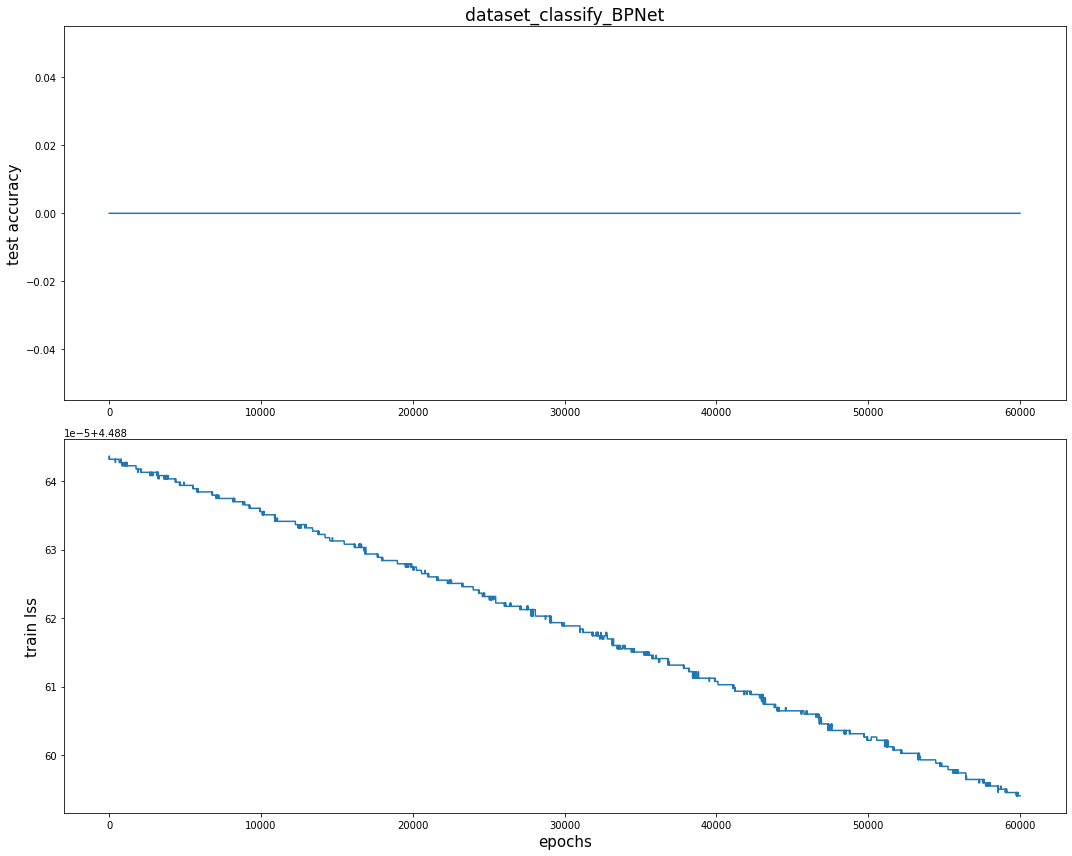

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #training and test set split function
import torch
import torch.nn.functional as Fun

lr        = 0.00001 # learning rate
epochs    = 60000  # training round number 
n_feature = 3    # input node (x,y,z)
n_hidden  = 20   # hidden layer
n_output  = 89   # output node (89 classes)


# def data_gen(data):
#   newData = np.zeros((89,100,3))
#   index = 0
#   for i in range(0,265,3):
#     newData[index] = data.iloc[:,[i,i+1,i+2]].values
#     index = index + 1    
#   return newData

# def label_gen():
#   combined_labels = np.zeros((89,100,89))
#   for i in range(89):
#     for j in range(100):
#       combined_labels[i][j][i]=1
#   return combined_labels

# sampled_train_data[13] and sampled_test_data[13] has problem, so abondon it.
# put all data into 3 columns, 100*17*89=151300. This is training set
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

# put sampled_train_data[0] data into 3 columns. This is test set.
def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

# create labels for all data. This is labels for training set
def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

# create labels for sampled_test_data[0] data. This is labels for test set
def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = sampled_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,sampled_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(sampled_test_data[0])
y_test = label_gen2()

# x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.2,random_state=22)

# normalization here
min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.fit_transform(x_test)

# change data to tensor
x_train=torch.FloatTensor(x_train)
y_train=torch.LongTensor(y_train)
x_test=torch.FloatTensor(x_test)
y_test=torch.LongTensor(y_test)

#2.create BP Neural Network
class BPNetModel(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(BPNetModel, self).__init__()
        self.hiddden= torch.nn.Linear(n_feature,n_hidden)#define hidden layer
        self.out=torch.nn.Linear(n_hidden,n_output)#define output layer
    def forward(self,x):
        x=Fun.relu(self.hiddden(x)) #hidden layer activation function use relu() function
        out=Fun.softmax(self.out(x),dim=1) #output layer use softmax() function
        return out
#3.Define the optimizer and loss function
net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #Call the network
optimizer=torch.optim.Adam(net.parameters(),lr=lr) #Use the Adam Optimizer and set the learning rate
loss_fun=torch.nn.CrossEntropyLoss() #The cross entropy loss function is generally used for multi-classification

#4.train data
loss_steps=np.zeros(epochs) #an array([ 0., 0., 0., 0., 0.]) contains 0, number is epochs
accuracy_steps=np.zeros(epochs)

for epoch in range(epochs):
    y_pred=net(x_train) #Forward propagation
    loss=loss_fun(y_pred,y_train)#Comparison of predicted and real values
    optimizer.zero_grad() #Gradient reset to 0
    loss.backward() #Back propagation
    optimizer.step() #Update gradient
    loss_steps[epoch]=loss.item()# store loss
    running_loss = loss.item()
    # print(f"{epoch} training，loss={running_loss}".format(epoch,running_loss))
    with torch.no_grad(): #Below is the calculation of no gradients, mainly used by the test set, no need to calculate gradients anymore
        y_test_pred=net(x_test)
        correct=(torch.argmax(y_test_pred)==y_test).type(torch.FloatTensor)
        accuracy_steps[epoch]=correct.mean()
    # print("accuracy", accuracy_steps[epoch])

#5.Plot loss function and precision
fig_name="dataset_classify_BPNet"
fontsize=15
fig,(ax1,ax2)=plt.subplots(2,figsize=(15,12),sharex=False)
ax1.plot(accuracy_steps)
ax1.set_ylabel("test accuracy",fontsize=fontsize)
ax1.set_title(fig_name,fontsize="xx-large")
ax2.plot(loss_steps)
ax2.set_ylabel("train lss",fontsize=fontsize)
ax2.set_xlabel("epochs",fontsize=fontsize)
plt.tight_layout()
plt.show()

In [ ]:
res = np.zeros(8900)
index = 0
for pred in y_test_pred:
  res[index] = np.argmax(pred)
  index = index + 1
res
  # pred = np.zeros(8900)
  # for i in range(8900):
  #   pred[i] = np.argmax(y_test_pred[i])
  # pred_label = np.zeros((8900,89))
  # index = 0
  # for label in pred:
  #   pred_label[index][int(label)] = 1
  #   index = index + 1

array([37., 37., 37., ..., 37., 37., 37.])

## **Xgboost**

Old data generation

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
import time

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = sampled_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,sampled_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(sampled_test_data[0])
y_test = label_gen2()

New data generation

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
import time

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = normalize_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,normalize_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(normalize_test_data[0])
y_test = label_gen2()

Xgboost with old dataset

In [ ]:
import time
# X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=100)

xgb_train=xgb.DMatrix(x_train,label=y_train)
xgb_test=xgb.DMatrix(x_test,label=y_test)



# Set the model parameters

params={
    'eta': 0.00001,
    'max_depth': 12,
    'subsample': 0.5,
    'objective': 'multi:softmax',
    'nthread': -1,
    'silent': 1,
    'booster': 'gbtree',
    'num_class': 89
}

watchlist=[(xgb_train,'train'),(xgb_test,'test')]
# Set up training rounds. 1000 rounds here
num_round=50
start = time.clock()
bst=xgb.train(params,
              xgb_train,
              num_round,
              watchlist,
              verbose_eval=10) # display 10 batch per time
end = time.clock()
runTime = end - start
print("runtime：", runTime)
# prediction

pred=bst.predict(xgb_test)
# print(pred)

# evaluation

# error_rate=np.sum(pred!=test.lable)/test.lable.shape[0]
error_rate=np.sum(pred!=y_test)/y_test.shape[0]

# This is the error rate of test set
print('test set error rate(softmax):{}'.format(error_rate))

# this is the accuracy of the test set
accuray=1-error_rate
print('test set accuracy：%.4f' %accuray)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[0]	train-merror:0.223318	test-merror:0.403371
[10]	train-merror:0.172016	test-merror:0.316517
[20]	train-merror:0.169742	test-merror:0.309888
[30]	train-merror:0.16959	test-merror:0.310112
[40]	train-merror:0.167964	test-merror:0.308427
[49]	train-merror:0.167984	test-merror:0.311685
runtime： 477.366134
test set error rate(softmax):0.311685393258427
test set accuracy：0.6883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Xgboost with new dataset

In [ ]:
import time
# X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=100)

xgb_train=xgb.DMatrix(x_train,label=y_train)
xgb_test=xgb.DMatrix(x_test,label=y_test)



# Set the model parameters

params={
    'eta': 0.00001,
    'max_depth': 12,
    'subsample': 0.5,
    'objective': 'multi:softmax',
    'nthread': -1,
    'silent': 1,
    'booster': 'gbtree',
    'num_class': 89
}

watchlist=[(xgb_train,'train'),(xgb_test,'test')]
# Set up training rounds. 1000 rounds here
num_round=50
start = time.clock()
bst=xgb.train(params,
              xgb_train,
              num_round,
              watchlist,
              verbose_eval=10) # display 10 batch per time
end = time.clock()
runTime = end - start
print("runtime：", runTime)
# prediction

pred=bst.predict(xgb_test)
# print(pred)

# evaluation

# error_rate=np.sum(pred!=test.lable)/test.lable.shape[0]
error_rate=np.sum(pred!=y_test)/y_test.shape[0]

# This is the error rate of test set
print('test set error rate(softmax):{}'.format(error_rate))

# this is the accuracy of the test set
accuray=1-error_rate
print('test set accuracy：%.4f' %accuray)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[0]	train-merror:0.089696	test-merror:0.068876
[10]	train-merror:0.08197	test-merror:0.057528
[20]	train-merror:0.081031	test-merror:0.056292
[30]	train-merror:0.081461	test-merror:0.057191
[40]	train-merror:0.081084	test-merror:0.057528
[49]	train-merror:0.081011	test-merror:0.055618
runtime： 365.54053
test set error rate(softmax):0.05561797752808989
test set accuracy：0.9444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


## **Supported Vector Machine**

In [ ]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import sklearn.svm as svm

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = sampled_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,sampled_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(sampled_test_data[0])
y_test = label_gen2()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score, recall_score
import sklearn.svm as svm

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = normalize_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,normalize_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(normalize_test_data[0])
y_test = label_gen2()

Old linear kernel without hyperparameter

In [ ]:
model = svm.SVC(kernel="linear", decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

In [ ]:
acu_train, acu_test, recall

(0.2485988103106411, 0.05539325842696629, 0.05539325842696629)

Old linear kernel with penalty factor C=60

In [ ]:
model = svm.SVC(kernel="linear", C=60, decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

In [ ]:
acu_train, acu_test, recall

(0.2876734963648381, 0.08831460674157303, 0.08831460674157304)

New linear kernel with penalty factor C=60,70,80,90,100. Best result C=100, accuracy training=0.9068, accuracy test=0.9683, runtime=1631second

In [ ]:
factor = [60,70,80,90,100]


for f in factor:
  start = time.clock()
  model = svm.SVC(kernel="linear", C=f, decision_function_shape="ovo")
  model.fit(x_train, y_train)
  acu_train = model.score(x_train, y_train)
  acu_test = model.score(x_test, y_test)
  y_pred = model.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  end = time.clock()
  runTime = end - start
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


runtime： 1928.375983
accuracy training:  0.9040185062789161
accuracy test:  0.9698876404494382
recall:  0.9698876404494383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


runtime： 1830.000005
accuracy training:  0.9049570389953734
accuracy test:  0.9691011235955056
recall:  0.9691011235955056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


runtime： 1737.5279649999998
accuracy training:  0.9058691341705222
accuracy test:  0.9686516853932584
recall:  0.9686516853932585


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


runtime： 1676.316594
accuracy training:  0.9062723066754792
accuracy test:  0.9682022471910112
recall:  0.9682022471910112
runtime： 1631.4721289999989
accuracy training:  0.9068208856576339
accuracy test:  0.968314606741573
recall:  0.9683146067415731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


New Poly kernel with penalty factor C=60, degree=6,7,8,9,10. Best result C=60, degree=7, accuracy training=0.9159, accuracy test=0.9682, runtime=700second

In [ ]:
factorDegree = [6,7,8,9,10]

for f in factorDegree:
  start = time.clock()
  model = svm.SVC(kernel="poly", C=60, degree=f, decision_function_shape="ovo")
  model.fit(x_train, y_train)
  acu_train = model.score(x_train, y_train)
  acu_test = model.score(x_test, y_test)
  y_pred = model.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")
  end = time.clock()
  runTime = end - start
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


runtime： 1423.537393
accuracy training:  0.7913879709187046
accuracy test:  0.8608988764044944
recall:  0.8608988764044945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


runtime： 699.5010009999999
accuracy training:  0.9159616655651025
accuracy test:  0.9682022471910112
recall:  0.9682022471910112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


runtime： 1509.473007
accuracy training:  0.783212161269002
accuracy test:  0.8591011235955056
recall:  0.8591011235955055


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


runtime： 790.3992910000006
accuracy training:  0.9033113020489094
accuracy test:  0.9617977528089887
recall:  0.9617977528089887
runtime： 1662.2178320000003
accuracy training:  0.7691209517514871
accuracy test:  0.8422471910112359
recall:  0.8422471910112359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


Old Poly kernel with penalty factor C=60, degree=10.

In [ ]:
acu_train, acu_test, recall

(0.5904626569729016, 0.6943820224719102, 0.69438202247191)

Old SVM with rbf kernel

In [ ]:
start = time.clock()

model = svm.NuSVC(kernel="rbf", decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

end = time.clock()
runTime = end - start
print("tuntime：", runTime)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


tuntime： 4191.7279069999995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


In [ ]:
acu_train, acu_test, recall

(0.4771381361533377, 0.1347191011235955, 0.13471910112359547)

In [ ]:
factor = [0.01, 0.1, 1, 10]

for f in factor:
  start = time.clock()

  model = svm.SVC(kernel="rbf", C=100, gamma=f, decision_function_shape="ovo")
  model.fit(x_train, y_train)
  acu_train = model.score(x_train, y_train)
  acu_test = model.score(x_test, y_test)
  y_pred = model.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  end = time.clock()
  runTime = end - start
  print("tuntime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


tuntime： 3343.528816
accuracy training:  0.8662062128222076
accuracy test:  0.9473033707865168
recall:  0.9473033707865168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


tuntime： 2279.8495219999986
accuracy training:  0.8957105089226702
accuracy test:  0.9678651685393258
recall:  0.9678651685393258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


tuntime： 1263.8634129999991
accuracy training:  0.909319233311302
accuracy test:  0.9678651685393258
recall:  0.967865168539326
tuntime： 900.9273329999996
accuracy training:  0.9163714474553867
accuracy test:  0.9665168539325842
recall:  0.9665168539325844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


## **Naive Bayes**

In [8]:
import pandas as pd
import numpy as np
from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, recall_score

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = normalize_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,normalize_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(normalize_test_data[0])
y_test = label_gen2()

Gaussian: feature variables are continuous variables that fit the Gaussian distribution, such as the height of a person or the length of an object

In [10]:
import time

start = time.clock()
gaussian = naive_bayes.GaussianNB()
gaussian.fit(x_train, y_train)
acu_train = gaussian.score(x_train, y_train)
end = time.clock()
runTime = end - start

acu_test = gaussian.score(x_test, y_test)
y_pred = gaussian.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

print("runtime：", runTime)
print("accuracy training: ", acu_train)
print("accuracy test: ", acu_test)
print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


runtime： 0.752797000000001
accuracy training:  0.8807072042300066
accuracy test:  0.9479775280898877
recall:  0.9479775280898877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


Multinomial: The feature variable is a discrete variable and conforms to a multinomial distribution

In [12]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.fit_transform(x_test)

start = time.clock()
multi = naive_bayes.MultinomialNB()
multi.fit(x_train, y_train)
acu_train = multi.score(x_train, y_train)
end = time.clock()
runTime = end - start

acu_test = multi.score(x_test, y_test)
y_pred = multi.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

print("runtime：", runTime)
print("accuracy training: ", acu_train)
print("accuracy test: ", acu_test)
print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


runtime： 0.3112239999999957
accuracy training:  0.6107402511566424
accuracy test:  0.5342696629213484
recall:  0.5342696629213483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


Bernoulli: The feature variable is a Boolean variable that conforms to the 0/1 distribution

In [13]:
start = time.clock()
bernoul = naive_bayes.BernoulliNB()
bernoul.fit(x_train, y_train)
acu_train = bernoul.score(x_train, y_train)
end = time.clock()
runTime = end - start

acu_test = bernoul.score(x_test, y_test)
y_pred = bernoul.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

print("runtime：", runTime)
print("accuracy training: ", acu_train)
print("accuracy test: ", acu_test)
print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


runtime： 0.3012999999999977
accuracy training:  0.01125578321216127
accuracy test:  0.011348314606741574
recall:  0.011348314606741574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


## **Logistic Regression Multiple Classification**

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = normalize_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,normalize_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(normalize_test_data[0])
y_test = label_gen2()

Solver: The optimization algorithm selects parameters
The optimization algorithm selects parameters, there are only five optional parameters, namely newton-cg,lbfgs,liblinear,sag,saga. The default is liblinear. the solver parameter determines our optimization method for the logistic regression loss function

In [18]:
solver_arr = ['liblinear','newton-cg','lbfgs','sag','saga']

for s in solver_arr:
  start = time.clock()
  clf = LogisticRegression(random_state=0,solver=s,multi_class='ovr')            
  clf.fit(x_train,y_train)
  acu_train = clf.score(x_train, y_train)
  end = time.clock()
  runTime = end - start

  acu_test = clf.score(x_test, y_test)
  y_pred = clf.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  print('current solver:', s)
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current solver: liblinear
runtime： 14.74568099999999
accuracy training:  0.6627032385988103
accuracy test:  0.6494382022471911
recall:  0.649438202247191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current solver: newton-cg
runtime： 124.248894
accuracy training:  0.6653998678122934
accuracy test:  0.6521348314606742
recall:  0.6521348314606742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current solver: lbfgs
runtime： 77.41050099999995
accuracy training:  0.6654130865829477
accuracy test:  0.652247191011236
recall:  0.652247191011236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current solver: sag
runtime： 32.58859300000006
accuracy training:  0.6628618638466622
accuracy test:  0.6559550561797752
recall:  0.6559550561797753
current solver: saga
runtime： 27.647673000000054
accuracy training:  0.6657369464639789
accuracy test:  0.6537078651685393
recall:  0.6537078651685394


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


multi_class: Classification method selection parameter, str type, optional parameters are ovr and multinomial

In [17]:
multi_class_para = ['ovr','multinomial']

for p in multi_class_para:
  start = time.clock()
  clf = LogisticRegression(random_state=0,solver='saga',multi_class=p)            
  clf.fit(x_train,y_train)
  acu_train = clf.score(x_train, y_train)
  end = time.clock()
  runTime = end - start

  acu_test = clf.score(x_test, y_test)
  y_pred = clf.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


runtime： 26.795345000000054
accuracy training:  0.6657369464639789
accuracy test:  0.6537078651685393
recall:  0.6537078651685394
runtime： 9.43273499999998
accuracy training:  0.6459352280237938
accuracy test:  0.6260674157303371
recall:  0.6260674157303371


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


C: inverse of the regularization factor λ, of type float, default 1.0. Must be a positive floating-point number. Like SVM, smaller values indicate stronger regularization.

In [21]:
factor_C = [0.01, 0.1, 1, 10, 50, 100]

for c in factor_C:
  start = time.clock()
  clf = LogisticRegression(random_state=0,C=c,solver='saga',multi_class='ovr')            
  clf.fit(x_train,y_train)
  acu_train = clf.score(x_train, y_train)
  end = time.clock()
  runTime = end - start

  acu_test = clf.score(x_test, y_test)
  y_pred = clf.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  print("current c:", c)
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current c: 0.01
runtime： 26.519957999999974
accuracy training:  0.11803701255783212
accuracy test:  0.10325842696629213
recall:  0.10325842696629213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current c: 0.1
runtime： 26.247509000000036
accuracy training:  0.28429610046265696
accuracy test:  0.24044943820224718
recall:  0.24044943820224718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current c: 1
runtime： 24.433243999999945
accuracy training:  0.6657369464639789
accuracy test:  0.6537078651685393
recall:  0.6537078651685394


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current c: 10
runtime： 29.065067999999997
accuracy training:  0.7884203569068077
accuracy test:  0.8376404494382023
recall:  0.8376404494382024


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


current c: 50
runtime： 44.23662300000001
accuracy training:  0.7788896232650363
accuracy test:  0.8293258426966292
recall:  0.8293258426966292
current c: 100
runtime： 51.715007000000014
accuracy training:  0.7716589557171183
accuracy test:  0.8203370786516854
recall:  0.8203370786516853


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


## **GBDT(Gradient Boosting Decision Tree)**

In [3]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score
import time

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = normalize_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,normalize_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(normalize_test_data[0])
y_test = label_gen2()

loss: loss function. There are two types: deviance, which uses log-likelihood, and exponential, which is the exponential loss, equivalent of AdaBoost. Cannot use exponential loss, ExponentialLoss requires 2 classes; got 89 class(es).

In [26]:
loss_para = ['deviance','exponential']

for lp in loss_para:
  start = time.clock()
  gbdt = GradientBoostingClassifier(loss=lp, learning_rate=0.1, n_estimators=5, subsample=1
                                    , min_samples_split=2, min_samples_leaf=1, max_depth=2
                                    , init=None, random_state=None, max_features=None
                                    , verbose=0, max_leaf_nodes=None, warm_start=False
                                    )

  gbdt.fit(x_train, y_train)
  end = time.clock()
  runTime = end - start

  acu_train = gbdt.score(x_train, y_train)
  acu_test = gbdt.score(x_test, y_test)
  y_pred = gbdt.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  print("current loss parameter:", lp)
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current loss parameter: deviance
runtime： 157.01002600000038
accuracy training:  0.7109385327164573
accuracy test:  0.7392134831460674
recall:  0.7392134831460672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


ValueError: ignored

learning_rate: step size, i.e. the weight reduction factor for each weak learner, default is 0.1, the range is 0-1, when the value is 1, it is equivalent to no weight reduction. A smaller learning_rate equals more iterations.

In [29]:
learning_rate_para = [1,0.1,0.01,0.001]

for lr in learning_rate_para:
  start = time.clock()
  gbdt = GradientBoostingClassifier(loss='deviance', learning_rate=lr, n_estimators=5, subsample=1
                                    , min_samples_split=2, min_samples_leaf=1, max_depth=2
                                    , init=None, random_state=None, max_features=None
                                    , verbose=0, max_leaf_nodes=None, warm_start=False
                                    )

  gbdt.fit(x_train, y_train)
  end = time.clock()
  runTime = end - start

  acu_train = gbdt.score(x_train, y_train)
  acu_test = gbdt.score(x_test, y_test)
  y_pred = gbdt.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  print("current learning rate:", lr)
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current learning rate: 1
runtime： 161.5513390000001
accuracy training:  0.0007799074686054197
accuracy test:  0.0005617977528089888
recall:  0.0005617977528089888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current learning rate: 0.1
runtime： 156.66557599999987
accuracy training:  0.7109385327164573
accuracy test:  0.7392134831460674
recall:  0.7392134831460672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current learning rate: 0.01
runtime： 156.90818500000023
accuracy training:  0.49923992068737605
accuracy test:  0.5493258426966292
recall:  0.5493258426966293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current learning rate: 0.001
runtime： 161.24655900000016
accuracy training:  0.4960343688037013
accuracy test:  0.5493258426966292
recall:  0.5493258426966292


n_estimators:Maximum number of weak learners, default is 100, usually considered together with learning_rate.

In [30]:
n_estimators_para = [5,10,50,100]

for e in n_estimators_para:
  start = time.clock()
  gbdt = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=e, subsample=1
                                    , min_samples_split=2, min_samples_leaf=1, max_depth=2
                                    , init=None, random_state=None, max_features=None
                                    , verbose=0, max_leaf_nodes=None, warm_start=False
                                    )

  gbdt.fit(x_train, y_train)
  end = time.clock()
  runTime = end - start

  acu_train = gbdt.score(x_train, y_train)
  acu_test = gbdt.score(x_test, y_test)
  y_pred = gbdt.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  print("current n_estimators:", e)
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current n_estimators: 5
runtime： 157.7530399999996
accuracy training:  0.7109385327164573
accuracy test:  0.7392134831460674
recall:  0.7392134831460672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current n_estimators: 10
runtime： 322.76027799999974
accuracy training:  0.7974884335756774
accuracy test:  0.8203370786516854
recall:  0.8203370786516855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current n_estimators: 50
runtime： 1654.5168400000002
accuracy training:  0.9114144084600132
accuracy test:  0.9217977528089888
recall:  0.9217977528089888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current n_estimators: 100
runtime： 3316.6722420000006
accuracy training:  0.9372835426305354
accuracy test:  0.952247191011236
recall:  0.952247191011236


n_estimators = 150

In [31]:
start = time.clock()
gbdt = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=150, subsample=1
                                  , min_samples_split=2, min_samples_leaf=1, max_depth=2
                                  , init=None, random_state=None, max_features=None
                                  , verbose=0, max_leaf_nodes=None, warm_start=False
                                  )

gbdt.fit(x_train, y_train)
end = time.clock()
runTime = end - start

acu_train = gbdt.score(x_train, y_train)
acu_test = gbdt.score(x_test, y_test)
y_pred = gbdt.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

print("current n_estimators:", e)
print("runtime：", runTime)
print("accuracy training: ", acu_train)
print("accuracy test: ", acu_test)
print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


current n_estimators: 100
runtime： 5000.581983
accuracy training:  0.9488697951090549
accuracy test:  0.957752808988764
recall:  0.9577528089887641


In [4]:
n_estimators_para = [200,300,400]

for e in n_estimators_para:
  start = time.clock()
  gbdt = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=e, subsample=1
                                    , min_samples_split=2, min_samples_leaf=1, max_depth=2
                                    , init=None, random_state=None, max_features=None
                                    , verbose=0, max_leaf_nodes=None, warm_start=False
                                    )

  gbdt.fit(x_train, y_train)
  end = time.clock()
  runTime = end - start

  acu_train = gbdt.score(x_train, y_train)
  acu_test = gbdt.score(x_test, y_test)
  y_pred = gbdt.predict(x_test)
  recall = recall_score(y_test, y_pred, average="macro")

  print("current n_estimators:", e)
  print("runtime：", runTime)
  print("accuracy training: ", acu_train)
  print("accuracy test: ", acu_test)
  print("recall: ", recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current n_estimators: 200
runtime： 8387.804429
accuracy training:  0.9570522141440846
accuracy test:  0.959438202247191
recall:  0.9594382022471909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current n_estimators: 300
runtime： 12632.179732
accuracy training:  0.9679643093192333
accuracy test:  0.9601123595505618
recall:  0.9601123595505618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


current n_estimators: 400
runtime： 16922.204946
accuracy training:  0.8496100462656972
accuracy test:  0.8744943820224719
recall:  0.8744943820224718
